# Emotion recognition using Emo-DB dataset and scikit-learn

### Database: Emo-DB database (free) 7 emotions
The data can be downloaded from http://emodb.bilderbar.info/index-1024.html

Code of emotions

W->Anger->Wut

L->Boredom->Langeweile

E->Disgust->Ekel

A->Anxiety/Fear->Angst

F->Happiness->Freude

T->Sadness->Trauer

N->Neutral


![image.png](http://iis-projects.ee.ethz.ch/images/thumb/a/a6/Emotions-on-arousal-valence-space.jpg/450px-Emotions-on-arousal-valence-space.jpg)

In [1]:
import requests 
import zipfile
import os
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st
import itertools
import sys
sys.path.append("../")
from plots_examples import plot_confusion_matrix, plot_ROC, plot_histogram

# disvoice imports
from phonation.phonation import Phonation
from articulation.articulation import Articulation
from prosody.prosody import Prosody
from phonological.phonological import Phonological
from replearning.replearning import RepLearning

# sklearn methods
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn import preprocessing
from sklearn import metrics
from sklearn import svm

Using TensorFlow backend.
/home/camilo/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/camilo/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/camilo/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/camilo/anaconda3/lib/python3.6/site-packages/tenso

## Download and unzip data


In [2]:
def download_url(url, save_path, chunk_size=128):
    r = requests.get(url, stream=True)
    with open(save_path, 'wb') as fd:
        for chunk in r.iter_content(chunk_size=chunk_size):
            fd.write(chunk)
            
PATH_data="http://emodb.bilderbar.info/download/download.zip"

In [3]:
download_url(PATH_data, "./download.zip")

In [4]:
with zipfile.ZipFile("./download.zip", 'r') as zip_ref:
    zip_ref.extractall("./emo-db/")

## prepare labels from the dataset

we will get labels for two classification problems: 

1. high vs. low arousal emotions
2. positive vs. negative emotions


In [5]:
PATH_AUDIO=os.path.abspath("./emo-db/wav")+"/"
labelsd='WLEAFTN'
labelshl=  [0, 1, 0, 0, 0, 1, 1] # 0 high arousal emotion, 1 low arousal emotions
labelspn=  [0, 0, 0, 0, 1, 0, 1] # 0 negative valence emotion, 1 positive valence emotion

hf=os.listdir(PATH_AUDIO)
hf.sort()

yArousal=np.zeros(len(hf))
yValence=np.zeros(len(hf))
for j in range(len(hf)):
    name_file=hf[j]
    label=hf[j][5]
    poslabel=labelsd.find(label)
    yArousal[j]=labelshl[poslabel]
    yValence[j]=labelspn[poslabel]

## compute features using disvoice: phonation, articulation, prosody, phonological

In [6]:
phonationf=Phonation()
articulationf=Articulation()
prosodyf=Prosody()
phonologicalf=Phonological()
replearningf=RepLearning('CAE')


Instructions for updating:
Colocations handled automatically by placer.


/home/camilo/anaconda3/lib/python3.6/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


### phonation features

In [7]:
Xphonation=phonationf.extract_features_path(PATH_AUDIO, static=True, plots=False, fmt="npy")
print(Xphonation.shape)

Processing 14a07Aa.wav:  69%|██████▉   | 368/535 [00:10<00:04, 40.87it/s]../phonation/phonation.py:161: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, data_audio=read(audio)
Processing 16b10Wb.wav: 100%|██████████| 535/535 [00:14<00:00, 36.70it/s]

(535, 28)


### articulation features

In [8]:
Xarticulation=articulationf.extract_features_path(PATH_AUDIO, static=True, plots=False, fmt="npy")
print(Xarticulation.shape)

Processing 03a01Fa.wav:   0%|          | 0/535 [00:00<?, ?it/s]/home/camilo/anaconda3/lib/python3.6/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)
Processing 14a07Aa.wav:  69%|██████▉   | 370/535 [02:49<01:36,  1.71it/s]../articulation/articulation.py:264: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, data_audio=read(audio)
Processing 16b10Wb.wav: 100%|██████████| 535/535 [04:01<00:00,  2.21it/s]

(535, 488)


### prosody features

In [9]:
Xprosody=prosodyf.extract_features_path(PATH_AUDIO, static=True, plots=False, fmt="npy")
print(Xprosody.shape)

Processing 14a07Aa.wav:  69%|██████▉   | 370/535 [01:12<00:33,  4.96it/s]../prosody/prosody.py:300: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, data_audio=read(audio)
Processing 14a07Fd.wav:  70%|██████▉   | 372/535 [01:12<00:29,  5.57it/s]../prosody/prosody.py:300: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, data_audio=read(audio)
Processing 14a07Na.wav:  70%|███████   | 375/535 [01:12<00:28,  5.52it/s]../prosody/prosody.py:300: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, data_audio=read(audio)
Processing 14a07Wc.wav:  70%|███████   | 377/535 [01:13<00:36,  4.32it/s]../prosody/prosody.py:300: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, data_audio=read(audio)
Processing 16b10Wb.wav: 100%|██████████| 535/535 [01:46<00:00,  5.04it/s]

(535, 103)


### phonological features

In [10]:
Xphonological=phonologicalf.extract_features_path(PATH_AUDIO, static=True, plots=False, fmt="npy")
print(Xphonological.shape)

Processing 14a07Aa.wav:  69%|██████▉   | 370/535 [02:24<00:57,  2.89it/s]/home/camilo/anaconda3/lib/python3.6/site-packages/phonet/phonet.py:235: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, signal=read(audio_file)
Processing 16b10Wb.wav: 100%|██████████| 535/535 [03:28<00:00,  2.57it/s]

(535, 108)


### representation learning features

In [11]:
Xrep=replearningf.extract_features_path(PATH_AUDIO, static=True, plots=False, fmt="npy")
print(Xrep.shape)

Processing 03a01Fa.wav:   0%|          | 0/535 [00:00<?, ?it/s]/home/camilo/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
Processing 08b01Wa.wav:  16%|█▌        | 83/535 [00:45<04:39,  1.62it/s]../replearning/AEspeech.py:95: UserWarning: There is Inf values in the Mel spectrogram
  warnings.warn("There is Inf values in the Mel spectrogram")
Processing 14a07Aa.wav:  69%|██████▉   | 370/535 [03:12<01:47,  1.53it/s]../replearning/AEspeech.py:77: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, signal=read(wav_file)
Processing 16b10Wb.wav: 100%|██████████| 535/535 [04:46<00:00,  1.87it/s]

(535, 1536)


### Emotion classification using an SVM classifier



In [12]:
def classify(X, y):
    
    # train test split
    Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.30, random_state=42)
    
    # z-score standarization
    scaler = preprocessing.StandardScaler().fit(Xtrain) 
    Xtrain=scaler.transform(Xtrain) 
    Xtest=scaler.transform(Xtest)
    Results=[]
    
    # randomized search cross-validation to optimize hyper-parameters of SVM 
    parameters = {'kernel':['rbf'], 'class_weight': ['balanced'], 
            'C':st.expon(scale=10),
            'gamma':st.expon(scale=0.01)}

    svc = svm.SVC()

    clf=RandomizedSearchCV(svc, parameters, n_jobs=4, cv=10, verbose=1, n_iter=200, scoring='balanced_accuracy')

    clf.fit(Xtrain, ytrain) # train the SVM
    accDev= clf.best_score_ # validation accuracy
    Copt=clf.best_params_.get('C') # best C
    gammaopt=clf.best_params_.get('gamma') # best gamma
    
    # train the SVM with the optimal hyper-parameters
    cls=svm.SVC(kernel='rbf', C=Copt, gamma=gammaopt, class_weight='balanced') 
    cls.fit(Xtrain, ytrain)
    ypred=cls.predict(Xtest) # test predictions
    
    # check the results
    acc=metrics.accuracy_score(ytest, ypred)
    score_test=cls.decision_function(Xtest)
    dfclass=metrics.classification_report(ytest, ypred,digits=4)

    # display the results
    
    plot_confusion_matrix(ytest, ypred, classes=["class 0", "class 1"], normalize=True)
    plot_ROC(ytest, score_test)
    plot_histogram(ytest, score_test, name_clases=["class 0", "class 1"])
    
    print("Accuracy: ", acc)
    print(dfclass)

    


## classify high vs. low arousal with the different feature sets

Fitting 10 folds for each of 500 candidates, totalling 5000 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  48 tasks      | elapsed:    8.4s
[Parallel(n_jobs=4)]: Done 2260 tasks      | elapsed:   14.6s
[Parallel(n_jobs=4)]: Done 5000 out of 5000 | elapsed:   22.3s finished


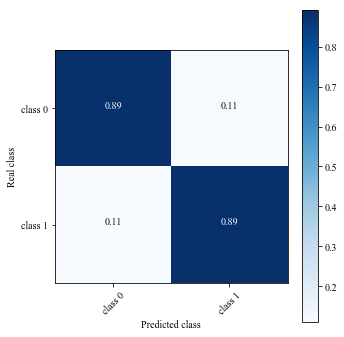

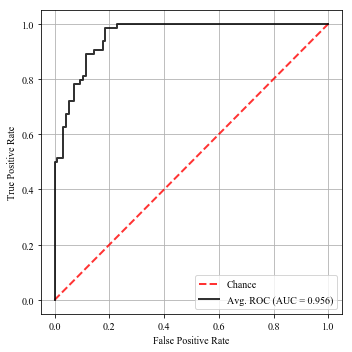

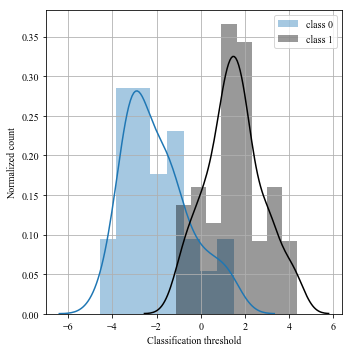

Accuracy:  0.8881987577639752
              precision    recall  f1-score   support

         0.0     0.9247    0.8866    0.9053        97
         1.0     0.8382    0.8906    0.8636        64

    accuracy                         0.8882       161
   macro avg     0.8815    0.8886    0.8844       161
weighted avg     0.8903    0.8882    0.8887       161



In [13]:
classify(Xphonation, yArousal)

Fitting 10 folds for each of 500 candidates, totalling 5000 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    2.9s
[Parallel(n_jobs=4)]: Done 376 tasks      | elapsed:   16.6s
[Parallel(n_jobs=4)]: Done 876 tasks      | elapsed:   37.5s
[Parallel(n_jobs=4)]: Done 1576 tasks      | elapsed:  1.1min
[Parallel(n_jobs=4)]: Done 2476 tasks      | elapsed:  1.7min
[Parallel(n_jobs=4)]: Done 3576 tasks      | elapsed:  2.4min
[Parallel(n_jobs=4)]: Done 4876 tasks      | elapsed:  3.2min
[Parallel(n_jobs=4)]: Done 5000 out of 5000 | elapsed:  3.3min finished


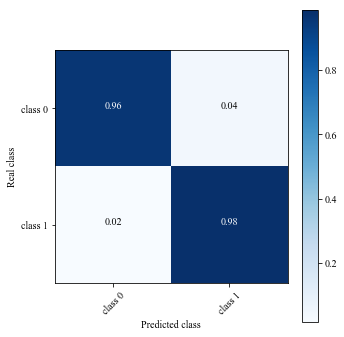

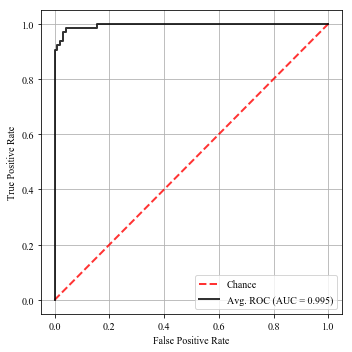

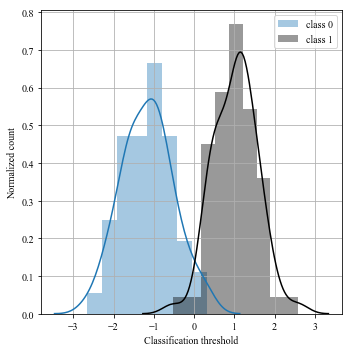

Accuracy:  0.968944099378882
              precision    recall  f1-score   support

         0.0     0.9894    0.9588    0.9738        97
         1.0     0.9403    0.9844    0.9618        64

    accuracy                         0.9689       161
   macro avg     0.9648    0.9716    0.9678       161
weighted avg     0.9699    0.9689    0.9691       161



In [14]:
classify(Xarticulation, yArousal)

Fitting 10 folds for each of 500 candidates, totalling 5000 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 200 tasks      | elapsed:    1.7s
[Parallel(n_jobs=4)]: Done 1400 tasks      | elapsed:    9.1s
[Parallel(n_jobs=4)]: Done 3400 tasks      | elapsed:   22.7s
[Parallel(n_jobs=4)]: Done 5000 out of 5000 | elapsed:   34.6s finished


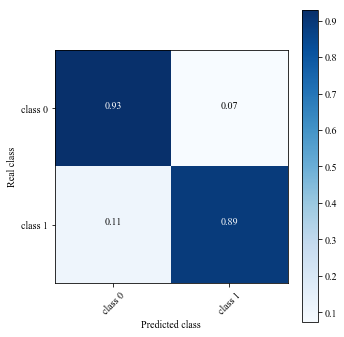

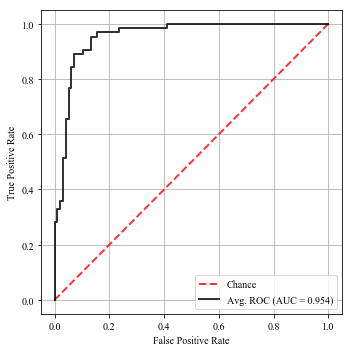

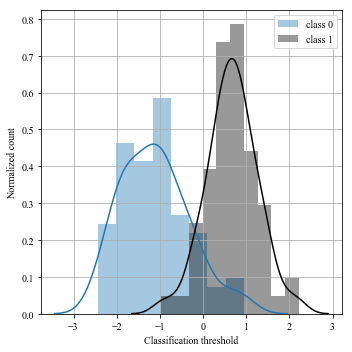

Accuracy:  0.9130434782608695
              precision    recall  f1-score   support

         0.0     0.9278    0.9278    0.9278        97
         1.0     0.8906    0.8906    0.8906        64

    accuracy                         0.9130       161
   macro avg     0.9092    0.9092    0.9092       161
weighted avg     0.9130    0.9130    0.9130       161



In [15]:
classify(Xprosody, yArousal)

Fitting 10 folds for each of 500 candidates, totalling 5000 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 200 tasks      | elapsed:    2.1s
[Parallel(n_jobs=4)]: Done 1400 tasks      | elapsed:   12.0s
[Parallel(n_jobs=4)]: Done 3400 tasks      | elapsed:   29.6s
[Parallel(n_jobs=4)]: Done 5000 out of 5000 | elapsed:   42.6s finished


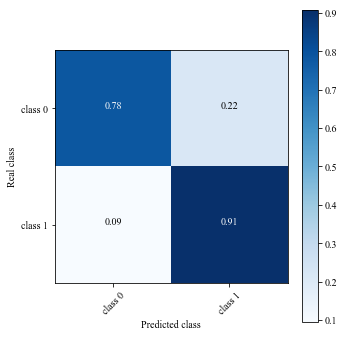

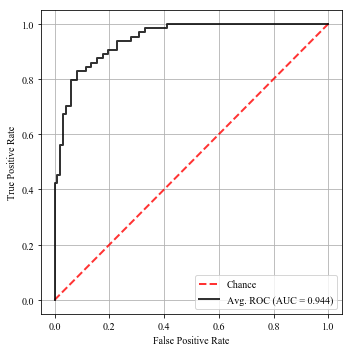

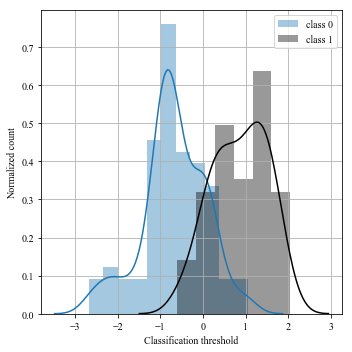

Accuracy:  0.8322981366459627
              precision    recall  f1-score   support

         0.0     0.9268    0.7835    0.8492        97
         1.0     0.7342    0.9062    0.8112        64

    accuracy                         0.8323       161
   macro avg     0.8305    0.8449    0.8302       161
weighted avg     0.8502    0.8323    0.8341       161



In [16]:
classify(Xphonological, yArousal)

Fitting 10 folds for each of 500 candidates, totalling 5000 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    8.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   32.4s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:  1.2min
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:  2.1min
[Parallel(n_jobs=4)]: Done 1242 tasks      | elapsed:  3.3min
[Parallel(n_jobs=4)]: Done 1792 tasks      | elapsed:  4.8min
[Parallel(n_jobs=4)]: Done 2442 tasks      | elapsed:  6.7min
[Parallel(n_jobs=4)]: Done 3192 tasks      | elapsed:  8.7min
[Parallel(n_jobs=4)]: Done 4042 tasks      | elapsed: 11.0min
[Parallel(n_jobs=4)]: Done 4992 tasks      | elapsed: 13.9min
[Parallel(n_jobs=4)]: Done 5000 out of 5000 | elapsed: 13.9min finished


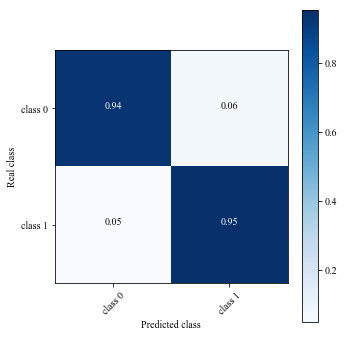

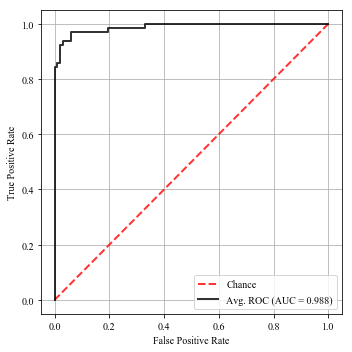

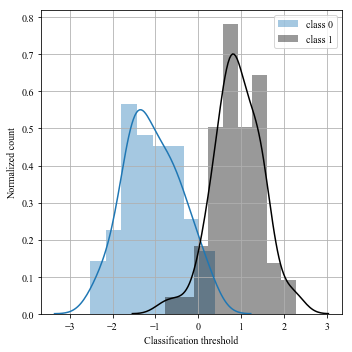

Accuracy:  0.9440993788819876
              precision    recall  f1-score   support

         0.0     0.9681    0.9381    0.9529        97
         1.0     0.9104    0.9531    0.9313        64

    accuracy                         0.9441       161
   macro avg     0.9393    0.9456    0.9421       161
weighted avg     0.9452    0.9441    0.9443       161



In [17]:
classify(Xrep, yArousal)

## classify positive vs. negative valence with the different feature sets

Fitting 10 folds for each of 500 candidates, totalling 5000 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 200 tasks      | elapsed:    1.3s
[Parallel(n_jobs=4)]: Done 1400 tasks      | elapsed:    8.5s
[Parallel(n_jobs=4)]: Done 3400 tasks      | elapsed:   20.9s
[Parallel(n_jobs=4)]: Done 5000 out of 5000 | elapsed:   30.2s finished


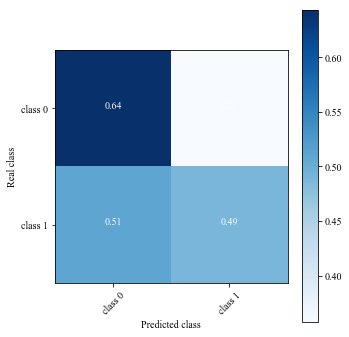

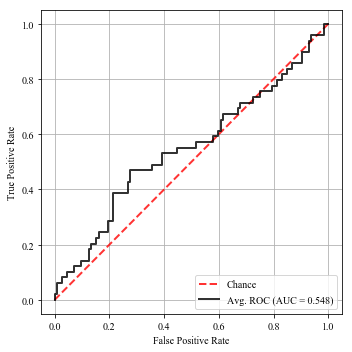

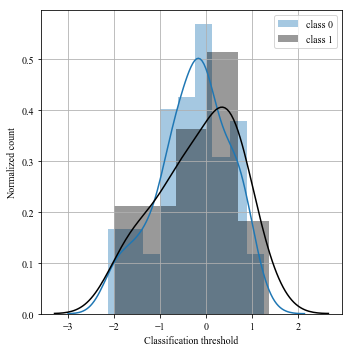

Accuracy:  0.5962732919254659
              precision    recall  f1-score   support

         0.0     0.7423    0.6429    0.6890       112
         1.0     0.3750    0.4898    0.4248        49

    accuracy                         0.5963       161
   macro avg     0.5586    0.5663    0.5569       161
weighted avg     0.6305    0.5963    0.6086       161



In [18]:
classify(Xphonation, yValence)

Fitting 10 folds for each of 500 candidates, totalling 5000 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    4.0s
[Parallel(n_jobs=4)]: Done 376 tasks      | elapsed:   18.7s
[Parallel(n_jobs=4)]: Done 876 tasks      | elapsed:   44.2s
[Parallel(n_jobs=4)]: Done 1576 tasks      | elapsed:  1.3min
[Parallel(n_jobs=4)]: Done 2476 tasks      | elapsed:  1.9min
[Parallel(n_jobs=4)]: Done 3576 tasks      | elapsed:  2.6min
[Parallel(n_jobs=4)]: Done 4876 tasks      | elapsed:  3.5min
[Parallel(n_jobs=4)]: Done 5000 out of 5000 | elapsed:  3.6min finished


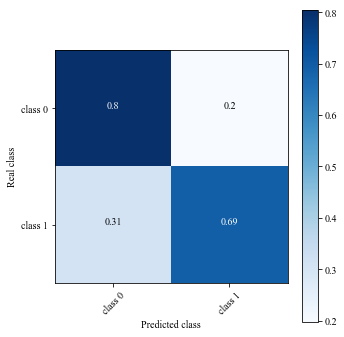

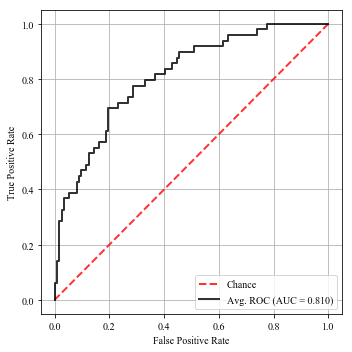

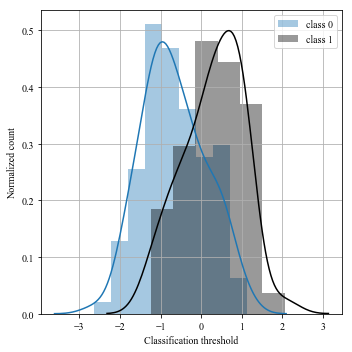

Accuracy:  0.7701863354037267
              precision    recall  f1-score   support

         0.0     0.8571    0.8036    0.8295       112
         1.0     0.6071    0.6939    0.6476        49

    accuracy                         0.7702       161
   macro avg     0.7321    0.7487    0.7386       161
weighted avg     0.7811    0.7702    0.7741       161



In [19]:
classify(Xarticulation, yValence)

Fitting 10 folds for each of 500 candidates, totalling 5000 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 128 tasks      | elapsed:    2.0s
[Parallel(n_jobs=4)]: Done 728 tasks      | elapsed:    9.0s
[Parallel(n_jobs=4)]: Done 1728 tasks      | elapsed:   20.4s
[Parallel(n_jobs=4)]: Done 3128 tasks      | elapsed:   37.3s
[Parallel(n_jobs=4)]: Done 4928 tasks      | elapsed:  1.0min
[Parallel(n_jobs=4)]: Done 5000 out of 5000 | elapsed:  1.1min finished


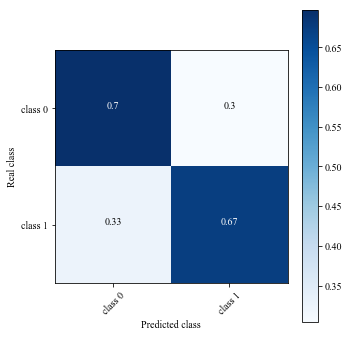

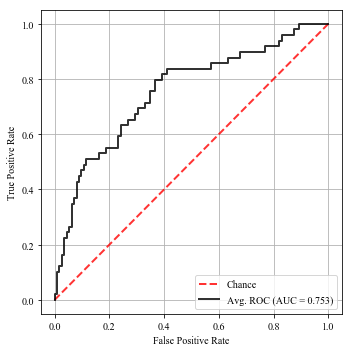

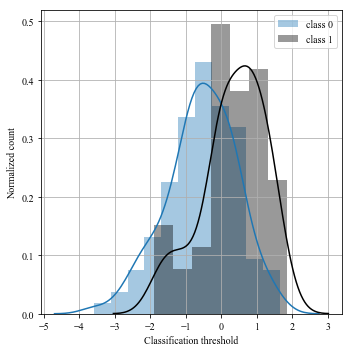

Accuracy:  0.6894409937888198
              precision    recall  f1-score   support

         0.0     0.8298    0.6964    0.7573       112
         1.0     0.4925    0.6735    0.5690        49

    accuracy                         0.6894       161
   macro avg     0.6612    0.6849    0.6631       161
weighted avg     0.7271    0.6894    0.7000       161



In [20]:
classify(Xprosody, yValence)

Fitting 10 folds for each of 500 candidates, totalling 5000 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 128 tasks      | elapsed:    1.8s
[Parallel(n_jobs=4)]: Done 728 tasks      | elapsed:    9.1s
[Parallel(n_jobs=4)]: Done 1728 tasks      | elapsed:   22.4s
[Parallel(n_jobs=4)]: Done 3128 tasks      | elapsed:   39.1s
[Parallel(n_jobs=4)]: Done 4928 tasks      | elapsed:  1.0min
[Parallel(n_jobs=4)]: Done 5000 out of 5000 | elapsed:  1.1min finished


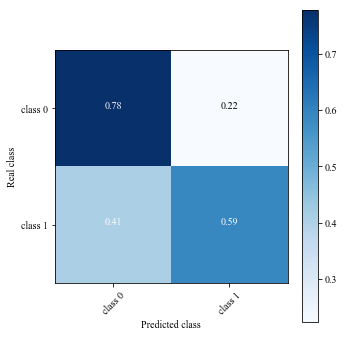

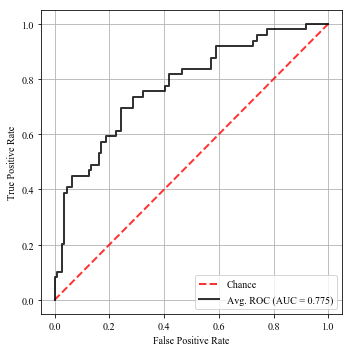

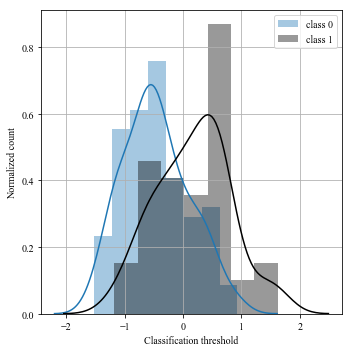

Accuracy:  0.7204968944099379
              precision    recall  f1-score   support

         0.0     0.8131    0.7768    0.7945       112
         1.0     0.5370    0.5918    0.5631        49

    accuracy                         0.7205       161
   macro avg     0.6751    0.6843    0.6788       161
weighted avg     0.7291    0.7205    0.7241       161



In [21]:
classify(Xphonological, yValence)

Fitting 10 folds for each of 500 candidates, totalling 5000 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    9.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   34.8s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:  1.4min
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:  2.3min
[Parallel(n_jobs=4)]: Done 1242 tasks      | elapsed:  3.6min
[Parallel(n_jobs=4)]: Done 1792 tasks      | elapsed:  5.4min
[Parallel(n_jobs=4)]: Done 2442 tasks      | elapsed:  7.6min
[Parallel(n_jobs=4)]: Done 3192 tasks      | elapsed: 10.1min
[Parallel(n_jobs=4)]: Done 4042 tasks      | elapsed: 13.2min
[Parallel(n_jobs=4)]: Done 4992 tasks      | elapsed: 16.7min
[Parallel(n_jobs=4)]: Done 5000 out of 5000 | elapsed: 16.7min finished


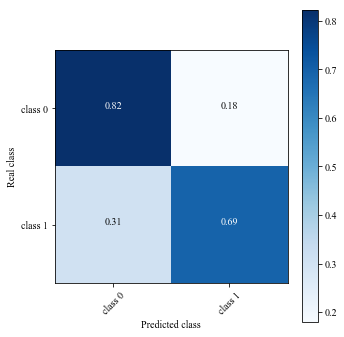

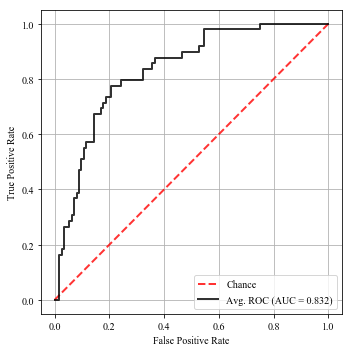

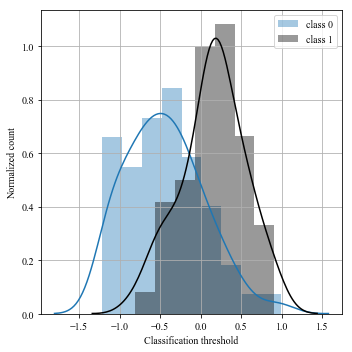

Accuracy:  0.782608695652174
              precision    recall  f1-score   support

         0.0     0.8598    0.8214    0.8402       112
         1.0     0.6296    0.6939    0.6602        49

    accuracy                         0.7826       161
   macro avg     0.7447    0.7577    0.7502       161
weighted avg     0.7898    0.7826    0.7854       161



In [22]:
classify(Xrep, yValence)